# LiCl ion pair dissociation in water
This notebook will show you how to setup a keras SNN and do some ANN assisted TPS with full atomistic inputs on a system in which the solvent plays an important role.

In [1]:
# Basic imports
%matplotlib inline
import os
import openpathsampling as paths
import numpy as np
import matplotlib.pyplot as plt
import openpathsampling.engines.openmm as peng_omm
from simtk.openmm import app
import simtk.openmm as mm
import simtk.unit as unit
from openmmtools.integrators import VVVRIntegrator
import mdtraj as md

In [2]:
# get the logging running
%run ../resources/logconf.py

wdir = '/homeloc/scratch/hejung/arcd_scratch/LiCl/'
#wdir = None
cur_dir = os.path.abspath(os.getcwd())
if wdir is not None:
    os.chdir(wdir)

import logging.config
logging.config.dictConfig(LOGCONFIG)

In [3]:
from keras import optimizers, regularizers
import arcd

Using TensorFlow backend.


In [3]:
# setup openMM integrator and system
forcefield = app.ForceField(os.path.join(cur_dir, 'forcefield/tip3p_standard.xml'))
pdb = app.PDBFile(os.path.join(cur_dir, 'LiCl_solv.pdb'))
system = forcefield.createSystem(
    pdb.topology, 
    nonbondedMethod=app.PME, 
    nonbondedCutoff=1.0*unit.nanometers,
    constraints=app.HBonds, 
    rigidWater=True,
    ewaldErrorTolerance=0.0005
)
integrator = VVVRIntegrator(
    330*unit.kelvin, 
    1.0/unit.picoseconds, 
    2.0*unit.femtoseconds)
integrator.setConstraintTolerance(0.00001)

template = peng_omm.snapshot_from_pdb(os.path.join(cur_dir, 'LiCl_solv.pdb'))
#openmm_properties = {'OpenCLPrecision': 'mixed'}
engine_options = {
    'n_frames_max': 25000,
    'nsteps_per_frame': 10
                  }
engine = peng_omm.Engine(template.topology,
                         system,
                         integrator,
                         #openmm_properties=openmm_properties,
                         options=engine_options
                         )
engine.name = '330K'
engine.initialize(platform='CPU')

In [5]:
# load states and initial TP from storage
old_storage = paths.Storage('initial_TPs.nc', 'r')
ion_dist = old_storage.cvs.find('ion_dist')
bound = old_storage.volumes.find('bound')
unbound = old_storage.volumes.find('unbound')

In [6]:
tps = paths.TPSNetwork.from_states_all_to_all([bound, unbound])

# do arcd stuff:
- create coordinate transformation function
- create model
- create wrapper object, trainer, trainset and history
- then the OPS interaction stuff: selector and training hook

In [11]:
## symmetry functions and internal coordinates
# fine tuned after plots in plot_symmetry_funcs notebook
# but we take some more symmetry funcs for the cluster
# fine tuned after plots in plot_symmetry_funcs notebook
cutoff = 1. # consider G5 worst case scenarios for cutoff!
g2_parms = [[200., 0.25], [200., 0.4], [200., 0.55], [200., 0.7], [200., 0.85]] # eta, r_s

g5_etas_rs = [[120., 0.25],
              [120., 0.4],
              [120., 0.55],
              [120., 0.7],
              [120., 0.85]
             ]

zetas = [
        1,
        2,
        4,
        16,
        64,
        ]

g5_parms = [[eta, r_s, zeta, lamb] for (eta, r_s) in g5_etas_rs for zeta in zetas for lamb in [+1., -1.]]

g_parms = [g2_parms, g5_parms]

mol_idxs, solv_idxs = arcd.coords.symmetry.generate_indices(template.topology.mdtraj,
                                                            ['HOH'],
                                                            solvent_atelements=[['O', 'H']],
                                                            reactant_selection='index 0 or index 1')

sf_parms = {'mol_idxs': mol_idxs, 'solv_idxs': solv_idxs, 'g_parms': g_parms,
            'cutoff': cutoff, 'n_per_solv': [[1., 2.]], 'rho_solv': [33.]}

sf_transform = paths.MDTrajFunctionCV('sf_transform', arcd.coords.symmetry.transform,
                               template.topology, **sf_parms)


ic_parms = {}
custom_cv_func = md.compute_distances
dist_atom_indices = np.array([[0, 1]])


def transform_func(mdtra, sf_parms, dist_atom_indices):
    import mdtraj as md
    from arcd.coords.symmetry import sf
    import numpy as np
    return np.concatenate([sf(mdtra, **sf_parms),
                           md.compute_distances(mdtra, dist_atom_indices)],
                          axis=1)
    

descriptor_transform = paths.MDTrajFunctionCV('descriptor_transform', transform_func,
                                              template.topology, sf_parms=sf_parms, 
                                              dist_atom_indices=dist_atom_indices,
                                              cv_scalarize_numpy_singletons=False)


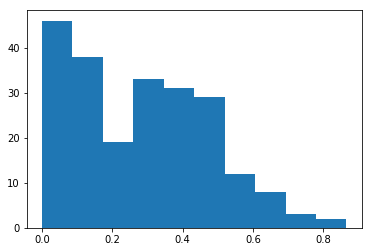

In [12]:
trans_coords = descriptor_transform(template)
cv_ndim = trans_coords.shape[0]
plt.hist(trans_coords);

In [13]:
import arcd.keras

In [14]:
hidden_parms = [{'units_factor': 1,
                 'activation': 'selu',
                 'use_bias': True,
                 'kernel_initializer': 'lecun_normal',
                 'bias_initializer': 'lecun_normal',
                 'kernel_regularizer': None,#regularizers.l1(l=0.00001),#regularizers.l1(),
                 'bias_regularizer': None,#regularizers.l1(),
                 'activity_regularizer':None,
                 'kernel_constraint':None,
                 'bias_constraint':None,
                 'dropout': 0.05,
                }]
hidden_parms = [{'units_factor': 1,
                 'activation': 'selu',
                 'use_bias': True,
                 'kernel_initializer': 'lecun_normal',
                 'bias_initializer': 'lecun_normal',
                 'kernel_regularizer': None,#regularizers.l1(l=0.00001),#regularizers.l1(),
                 'bias_regularizer': None,#regularizers.l1(),
                 'activity_regularizer':None,
                 'kernel_constraint':None,
                 'bias_constraint':None,
                 'dropout': 0.01,
                }
                for i in range(1,4)]
hidden_parms += [{'units_factor': 1,
                 'activation': 'selu',
                 'use_bias': True,
                 'kernel_initializer': 'lecun_normal',
                 'bias_initializer': 'lecun_normal',
                 'kernel_regularizer': None, #regularizers.l1(l=0.0001),
                 'bias_regularizer': None,#regularizers.l2(),
                 'activity_regularizer':None,
                 'kernel_constraint':None,
                 'bias_constraint':None,
                 'dropout': 0.1}]
optimizer = optimizers.adam(lr=1e-4)
# create a SNN with binomial loss to predict p_B
snn = arcd.keras.create_snn(ndim=cv_ndim, hidden_parms=hidden_parms,
                                 optimizer=optimizer, n_states=2,  # does not really matter if multi_state=False
                                 multi_state=False)

In [15]:
model = arcd.keras.EEKerasRCModel(snn, descriptor_transform,
                                 ee_params={'lr_0': 1e-4, 'lr_min': 1e-6, 'epochs_per_train': 5, 'interval': 3, 'window': 100})

In [16]:
# create a trainset
trainset = arcd.TrainSet([bound, unbound], descriptor_transform)

In [17]:
# the trainhook object takes any RC model and a trainset
trainhook = arcd.ops.TrainingHook(model=model, trainset=trainset)

In [18]:
selector = arcd.ops.RCModelSelector(model, descriptor_transform, [bound, unbound])

In [19]:
move_scheme = paths.MoveScheme(network=tps)
beta = 1. / (integrator.getTemperature() * unit.BOLTZMANN_CONSTANT_kB)
modifier = paths.RandomVelocities(beta=beta, engine=engine)
tw_strategy = paths.strategies.TwoWayShootingStrategy(modifier=modifier, selector=selector, engine=engine, group='TwoWayShooting')
move_scheme.append(tw_strategy)
move_scheme.append(paths.strategies.OrganizeByMoveGroupStrategy())
move_scheme.build_move_decision_tree()

In [20]:
initial_conditions = move_scheme.initial_conditions_from_trajectories(old_storage.trajectories[:])

No missing ensembles.
No extra ensembles.


In [21]:
storage = paths.Storage('simulation_data/LiCl_new_API.nc', 'w', template=template)

In [22]:
sampler = paths.PathSampling(storage=storage, sample_set=initial_conditions, move_scheme=move_scheme)

In [23]:
sampler.attach_hook(trainhook)

In [6]:
sampler.run(10)

Working on Monte Carlo cycle number 340
Running for 1 minute 18 seconds -  8.69 seconds per step
Estimated time remaining: 8 seconds
DONE! Completed 340 Monte Carlo cycles.


In [7]:
model = trainhook.model
trainset = trainhook.trainset

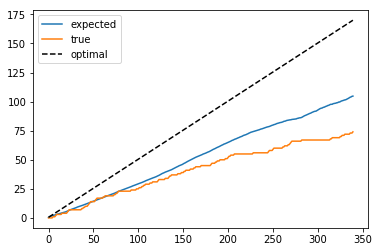

In [8]:
p_ex = np.array(model.expected_p)
plt.plot(np.cumsum(2*p_ex*(1 - p_ex)), label='expected')
plt.plot(np.cumsum(trainset.transitions), label='true')
plt.plot(np.cumsum(np.full_like(p_ex, 0.5)), 'k--', label='optimal')
plt.legend()

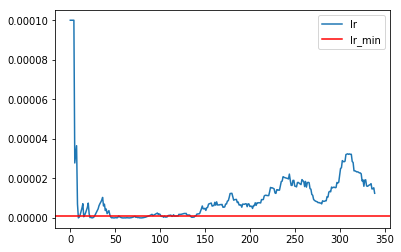

In [9]:
log = np.asarray(model.log_train_decision)
#plt.plot(np.cumsum(log[:,0]), label='train')
plt.plot(log[:,1], label='lr')
plt.axhline(model.ee_params['lr_min'], label='lr_min', color='red')
plt.legend()

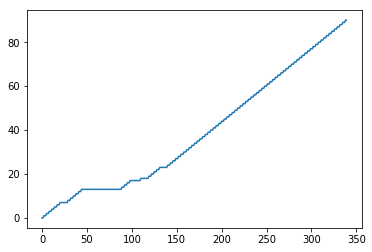

In [10]:
plt.plot(np.cumsum(log[:,0]))

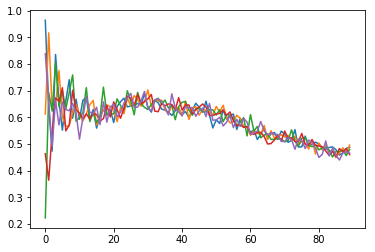

In [11]:
losses = np.asarray(model.log_train_loss)
plt.plot(losses)

In [12]:
loss_per_step = np.zeros((len(trainset), model.ee_params['epochs_per_train']))
c = 0
for i, p in enumerate(log):
    if p[0]:
        loss_per_step[i] = losses[c]
        c += 1
    else:
        loss_per_step[i] = np.zeros((model.ee_params['epochs_per_train'],))
    

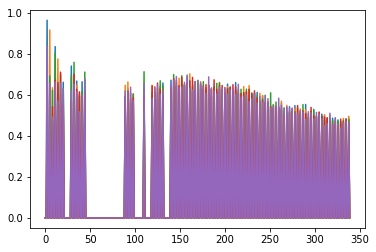

In [13]:
plt.plot(loss_per_step)

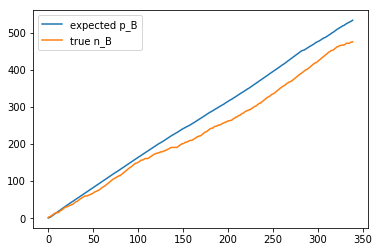

In [14]:
plt.plot(2.*np.cumsum(p_ex), label='expected p_B')
plt.plot(np.cumsum(trainset.shot_results[:,1]), label='true n_B')
plt.legend();

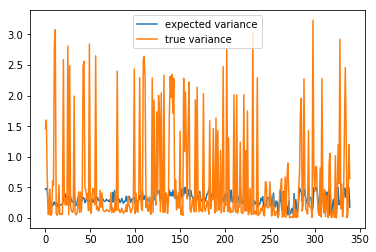

In [15]:
plt.plot(2.*p_ex[:,0]*(1.- p_ex[:,0]), label='expected variance')
plt.plot((2.*p_ex[:,0] - trainset.shot_results[:,1])**2, label='true variance')
plt.legend();

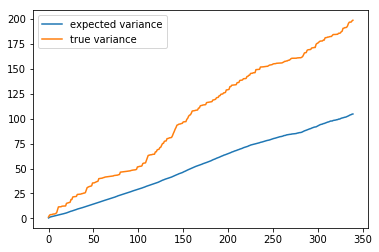

In [16]:
plt.plot(np.cumsum(2.*p_ex[:,0]*(1.- p_ex[:,0])), label='expected variance')
plt.plot(np.cumsum((2.*p_ex[:,0] - trainset.shot_results[:,1])**2), label='true variance')
plt.legend();

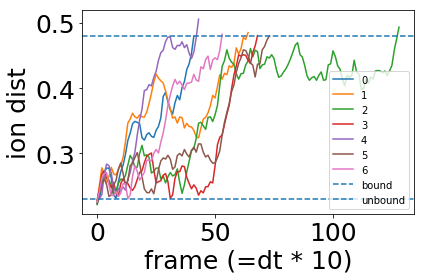

In [17]:
ion_dist = storage.cvs.find('ion_dist')
bound = storage.volumes.find('bound')
unbound = storage.volumes.find('unbound')
tras = []
tras_ops = []
for step in storage.steps[-50:]:
    if step.change.canonical.accepted:
        if bound(step.change.canonical.trials[0].trajectory[0]):
            tras.append(ion_dist(step.change.canonical.trials[0].trajectory))
            tras_ops.append(step.change.canonical.trials[0].trajectory)
        else:
            # append reversed tra
            tras.append(ion_dist(step.change.canonical.trials[0].trajectory.reversed))
            tras_ops.append(step.change.canonical.trials[0].trajectory.reversed)
#tras.append(ion_dist(storage.trajectories[-1]))
#tras.append(ion_dist(storage.trajectories[-10]))

for i, tra in enumerate(tras):
    plt.plot(np.arange(len(tra)), tra, label=i)

plt.axhline(bound.lambda_max, linestyle='--', label='bound')
plt.axhline(unbound.lambda_min, linestyle='--', label='unbound')
plt.xlabel('frame (=dt * 10)', size=25)
plt.ylabel('ion dist', size=25)
plt.tick_params(labelsize=25)
#plt.ylim(0., 1.)
plt.legend()
plt.tight_layout()

In [18]:
accepts = []
for step in storage.steps:
    if step.change.canonical.accepted:
        accepts.append(1.)
    else:
        accepts.append(0.)

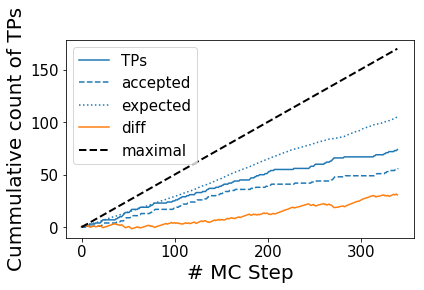

In [19]:
l, = plt.plot(np.cumsum(trainset.transitions), label='TPs');
plt.plot(np.cumsum(accepts), c=l.get_color(), ls='--', label='accepted');
plt.plot(np.cumsum(2*p_ex*(1 - p_ex)),c=l.get_color(), ls=':', label='expected');
plt.plot(np.cumsum(2*p_ex*(1 - p_ex))- np.cumsum(trainset.transitions), label='diff')
#plt.plot(np.cumsum(caccepts), c=l.get_color(), ls='--', lw=5)#, label='accepted');
plt.plot(np.linspace(0., len(trainset)/2., len(trainset)), c='k', ls='--', label='maximal', lw=2)
plt.legend(fontsize=15);
plt.ylabel('Cummulative count of TPs', size=20)
plt.xlabel('# MC Step', size=20)
plt.tick_params(labelsize=15)
#plt.xlim(0,2000)
#plt.ylim(0,1000)
plt.tight_layout()

In [20]:
from arcd.analysis import GradientMovieMaker

In [21]:
gmovie = GradientMovieMaker(trainhook.model, trainhook.model.descriptor_transform, storage.snapshots[-3].topology.mdtraj)

In [22]:
step = storage.steps[-3]
shot_snap = step.change.canonical.details.shooting_snapshot

In [23]:
# get indices of water around lithium and chloride
atom_indices = list(md.compute_neighbors(paths.Trajectory([shot_snap]).to_mdtraj(),
                                    trainhook.model.descriptor_transform.kwargs['sf_parms']['cutoff'],
                                    query_indices=trainhook.model.descriptor_transform.kwargs['sf_parms']['mol_idxs'],
                                    haystack_indices=np.concatenate(trainhook.model.descriptor_transform.kwargs['sf_parms']['solv_idxs'][0]))[0])
atom_indices += [0, 1]  # add the lithium and the chloride to gradient calculations
atom_indices = np.array(atom_indices)

In [24]:
mols = gmovie.topology.find_molecules()
print(mols[0:2])

[{Li1-Li}, {Cl1-Cl}]


In [25]:
anchor_mols = mols[0:2]

In [32]:
gmovie.movie_around_snapshot(shot_snap, 'movie.pdb', atom_indices=atom_indices, anchor_mols=anchor_mols)

In [26]:
gmovie.descriptor_transform_sqrt_eps

In [27]:
print([len(t) for t in tras_ops])

[42, 65, 129, 69, 44, 74, 54]


In [28]:
gmovie.color_by_gradient(tras_ops[0][::10], 'simulation_data/TP_by_grad.pdb', atom_indices=atom_indices, anchor_mols=anchor_mols)

In [29]:
storage.close()

In [4]:
storage = paths.Storage('simulation_data/LiCl_new_API.nc', 'a')

In [5]:
sampler = storage.pathsimulators[0]
sampler.restart_at_step(storage.steps[-1], storage)
trainhook = arcd.ops.TrainingHook(None, None, 100)
sampler.attach_hook(trainhook)

(WARNING)arcd.ops.selector: Restoring RCModelSelector without model.If used together with arcd.TrainingHook you can ignore this warning, otherwise please take care of resetting the model yourself.
